In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import os
import timm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#define variables specific to this model
subject = 'sub01'
roi = 'V2'
ensemble_model_name = 'model_weights_{}_{}_ensemble.pt'.format(subject, roi)

RAW_model_name = 'model_weights_{}_{}_RAW.pt'.format(subject, roi)
RAFT_model_name = 'model_weights_{}_{}_RAFT.pt'.format(subject, roi)
BDCN_model_name = 'model_weights_{}_{}_BDCN.pt'.format(subject, roi)
MFCC_model_name = 'model_weights_{}_{}_MFCC.pt'.format(subject, roi)

# define global variables / hyperparameters
batch_size = 16
num_epochs = 50
learning_rate = 0.001

# detect if GPU/CPU device
use_cuda = torch.cuda.is_available()
print('CUDA available:', use_cuda)

# set RNG seed for reproducibility
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

# setup gpu things
dtype = 'float32' if use_cuda else 'float64' # GPU does better with float32 numbers
torchtype = {'float32': torch.float32, 'float64': torch.float64}[dtype]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# flush out the cache
torch.cuda.empty_cache()

CUDA available: True


In [2]:
# Function that takes arrays x1, y1, x2, y2
# each y has dimensions (num_samples, num_classes)  
# finds the similar labels in y1 and y2
# uses the indices of similar labels to find the corresponding x1 and x2
# returns the x1, x2, y1
def find_similar_labels(x1, y1, x2, y2):
    # for every label in y1, see if there is a similar label in y2
    # if there is, add the corresponding x1 and x2 to the list
    # return the list of x1, x2, y1, y2
    x1_list = []
    x2_list = []
    y1_list = []
    for i, label in enumerate(y1):
        # labels are both floats, so check if they are close enough
        # if they are close enough, add the corresponding x1 and x2 to the list
        # if they are not close enough, do nothing
        # if there is no similar label, do nothing
        similar_label_idx = -1
        similar_label = False
        for j, label2 in enumerate(y2):
            if np.allclose(label, label2, atol=0.1):
                similar_label = True
                similar_label_idx = j
                break
        if similar_label:
            x1_list.append(x1[i])
            x2_list.append(x2[j])
            y1_list.append(label)
    return np.array(x1_list), np.array(x2_list), np.array(y1_list)

In [3]:
# Training a RNN with PyTorch for roi V1 with RAW data

# Load the entire training data into main memory
# This is a huge dataset, so we need to do this in chunks

#isolate subject of interests' data
num_subjects = 10
soi = subject
num_classes = -1

# read in every npy file in the directory Gunners_training_data/V1/RAW and store them in a list 
RAW_training_data = []
RAW_training_labels = []

RAFT_training_data = []
RAFT_training_labels = []

BDCN_training_data = []
BDCN_training_labels = []

MFCC_training_data = []
MFCC_training_labels = []

# load in every Nth file in the directory
culling_scale = 1

preprocessing = 'MFCC'
input_data_dims = (39,261)
input_channels = 1
# for each file in the MFCC directory
for i, file in enumerate(os.listdir('../Gunners_training_data/{}/{}'.format(roi, preprocessing))):
    # if the file name contains the soi string
    if not soi in file:
        continue
    # if the file is a .npy file
    if file.endswith('.npy'):
        # read in the file
        data = np.load('../Gunners_training_data/{}/{}/'.format(roi,preprocessing) + file, allow_pickle=True)
        
        # print out first voxel label
        # if i == 0:
        #     print(data[0][1][0])

        # for each sample, make sure its dimensions are correct, if not then skip it
        if data[0][0].shape != input_data_dims:
            # if the shape is larger than the input_data_dims, then crop it
            if data[0][0].shape[1] > input_data_dims[1]:
                data[0][0] = data[0][0][:,:input_data_dims[1]]
            if data[0][0].shape != input_data_dims:
                continue

        # for each sample, add the data to the training_data list
        data[0][0] = np.expand_dims(data[0][0],axis=0)
        MFCC_training_data.append(data[0][0])
        # for each sample, add the label to the training_labels list
        MFCC_training_labels.append(data[0][1])

num_classes = len(MFCC_training_labels[0])

preprocessing = 'RAW'
input_data_dims = (32,32,225)
input_channels = 225
# for each file in the RAW directory
for i, file in enumerate(os.listdir('../Gunners_training_data/{}/{}'.format(roi, preprocessing))):
    # if the file name contains the soi string
    if not soi in file:
        continue
    # if the file is a .npy file
    if file.endswith('.npy'):
        # read in the file
        data = np.load('../Gunners_training_data/{}/{}/'.format(roi,preprocessing) + file, allow_pickle=True)
        
        # print out first voxel label
        # if i == 0:
        #     print(data[0][1][0])

        # for each sample, make sure its dimensions are 32x32x225, if not then skip it
        if data[0][0].shape != input_data_dims:
            continue
        
        # for each sample, add the data to the training_data list
        RAW_training_data.append(data[0][0])

        # for each label, add the data to the training_data list
        RAW_training_labels.append(data[0][1])

# cull MFCCS that dont have RAW data and vice versa
MFCC_training_data = np.array(MFCC_training_data)
MFCC_training_labels = np.array(MFCC_training_labels)
RAW_training_data = np.array(RAW_training_data)
RAW_training_labels = np.array(RAW_training_labels)

print("Finding similar labels between MFCC and RAW")
MFCC_training_data, RAW_training_data, MFCC_training_labels = find_similar_labels(MFCC_training_data, MFCC_training_labels, RAW_training_data, RAW_training_labels)

preprocessing = 'RAFT'
input_data_dims = (32,32,222)
input_channels = 222
# for each file in the RAW directory
for i, file in enumerate(os.listdir('../Gunners_training_data/{}/{}'.format(roi, preprocessing))):
    # if the file name contains the soi string
    if not soi in file:
        continue
    # if the file is a .npy file
    if file.endswith('.npy'):
        # read in the file
        data = np.load('../Gunners_training_data/{}/{}/'.format(roi,preprocessing) + file, allow_pickle=True)
        
        
        # print out first voxel label
        # if i == 0:
        #     print(data[0][1][0])

        # for each sample, make sure its dimensions are 32x32x225, if not then skip it
        if data[0][0].shape != input_data_dims:
            continue
        
        # for each sample, add the data to the training_data list
        RAFT_training_data.append(data[0][0])

        # for each label, add the data to the training_data list
        RAFT_training_labels.append(data[0][1])


# cull MFCCs/RAW that dont have RAFT data and vice versa
RAFT_training_data = np.array(RAFT_training_data)
RAFT_training_labels = np.array(RAFT_training_labels)

print("Finding similar labels between MFCC and RAFT")
RAFT_training_data, MFCC_training_data, MFCC_training_labels = find_similar_labels(RAFT_training_data, RAFT_training_labels, MFCC_training_data, MFCC_training_labels)

preprocessing = 'BDCN'
input_data_dims = (32,32,75)
input_channels = 75
# for each file in the RAW directory
for i, file in enumerate(os.listdir('../Gunners_training_data/{}/{}'.format(roi, preprocessing))):
    # if the file name contains the soi string
    if not soi in file:
        continue
    # if the file is a .npy file
    if file.endswith('.npy'):
        # read in the file
        data = np.load('../Gunners_training_data/{}/{}/'.format(roi,preprocessing) + file, allow_pickle=True)
        
        
        # print out first voxel label
        # if i == 0:
        #     print(data[0][1][0])

        # for each sample, make sure its dimensions are 32x32x225, if not then skip it
        if data[0][0].shape != input_data_dims:
            continue
        
        # for each sample, add the data to the training_data list
        BDCN_training_data.append(data[0][0])

        # for each label, add the data to the training_data list
        BDCN_training_labels.append(data[0][1])


# cull MFCCs/RAW that dont have RAFT data and vice versa
BDCN_training_data = np.array(BDCN_training_data)
BDCN_training_labels = np.array(BDCN_training_labels)

print("Finding similar labels between MFCC and BDCN")
BDCN_training_data, MFCC_training_data, MFCC_training_labels = find_similar_labels(BDCN_training_data, BDCN_training_labels, MFCC_training_data, MFCC_training_labels)

print('Number of RAW training samples: ', len(RAW_training_data))
print('Number of MFCC training samples: ', len(MFCC_training_data))
print('Number of RAFT training samples: ', len(RAFT_training_data))
print('Number of BDCN training samples: ', len(BDCN_training_data))
print('Number of voxel activations (classes): ', num_classes)

# Only keep MFFC_training_labels; release memory of other label arrays
RAW_training_labels = None
RAFT_training_labels = None
BDCN_training_labels = None

#normalize all labels to be between -1 and 1
MFCC_training_labels = np.array(MFCC_training_labels)
MFCC_training_labels = (MFCC_training_labels - np.min(MFCC_training_labels)) / (np.max(MFCC_training_labels) - np.min(MFCC_training_labels))
#print the value range of the labels
print('Value range of labels: ', np.min(MFCC_training_labels), np.max(MFCC_training_labels))
num_classes = MFCC_training_labels[0].shape[0]
print('Number of voxel activations (classes): ', num_classes)
    
# verify the data is loaded correctly and is in numpy arrays
RAW_training_data = np.array(RAW_training_data)
RAFT_training_data = np.array(RAFT_training_data)
BDCN_training_data = np.array(BDCN_training_data)
MFCC_training_data = np.array(MFCC_training_data)

# combine all training data into one array for a pytorch Dataset object
RAW_training_data = torch.tensor(RAW_training_data).type(torchtype)
RAFT_training_data = torch.tensor(RAFT_training_data).type(torchtype)
BDCN_training_data = torch.tensor(BDCN_training_data).type(torchtype)
MFCC_training_data = torch.tensor(MFCC_training_data).type(torchtype)
training_labels = torch.tensor(MFCC_training_labels).type(torchtype)

# permute the data so that the first dimension is the number of samples, the second is the number of channels
# not viable for MFCC 2d data
RAW_training_data = RAW_training_data.permute(0,3,1,2)
RAFT_training_data = RAFT_training_data.permute(0,3,1,2)
BDCN_training_data = BDCN_training_data.permute(0,3,1,2)


#print the dims of training_data tensor
print('RAW_training_data tensor dims:', RAW_training_data.shape)
print('RAFT_training_data tensor dims:', RAFT_training_data.shape)
print('BDCN_training_data tensor dims:', BDCN_training_data.shape)
print('MFCC_training_data tensor dims:', MFCC_training_data.shape)
print('training_labels tensor dims:', training_labels.shape)

# create a dataset from the tensors
RAW_dataset = TensorDataset(RAW_training_data,training_labels)
RAFT_dataset = TensorDataset(RAFT_training_data,training_labels)
BDCN_dataset = TensorDataset(BDCN_training_data,training_labels)
MFCC_dataset = TensorDataset(MFCC_training_data,training_labels)

# split the data into training and validation sets
train_size = int(0.8 * len(RAW_training_data))
valid_size = len(RAW_training_data) - train_size

# create training and validation sets
RAW_dataset, RAW_validation_data = torch.utils.data.random_split(RAW_dataset, [train_size, valid_size])
RAFT_dataset, RAFT_validation_data = torch.utils.data.random_split(RAFT_dataset, [train_size, valid_size])
BDCN_dataset, BDCN_validation_data = torch.utils.data.random_split(BDCN_dataset, [train_size, valid_size])
MFCC_dataset, MFCC_validation_data = torch.utils.data.random_split(MFCC_dataset, [train_size, valid_size])

# # combine all the training datasets into a big one
# train_data = [RAW_dataset, RAFT_dataset, BDCN_dataset, MFCC_dataset]
# # concatenate all the validation datasets
# valid_data = torch.utils.data.ConcatDataset([RAW_validation_data, RAFT_validation_data, BDCN_validation_data, MFCC_validation_data])

# print out the range of values for labels
print('Value range of labels: ', np.min(MFCC_training_labels), np.max(MFCC_training_labels))


# create training and validation dataloaders

RAW_train_loader = DataLoader(RAW_dataset, batch_size = batch_size, shuffle=True)
RAFT_train_loader = DataLoader(RAFT_dataset, batch_size = batch_size, shuffle=True)
BDCN_train_loader = DataLoader(BDCN_dataset, batch_size = batch_size, shuffle=True)
MFCC_train_loader = DataLoader(MFCC_dataset, batch_size = batch_size, shuffle=True)

RAW_val_loader = DataLoader(RAW_validation_data, batch_size = batch_size, shuffle=False)
RAFT_val_loader = DataLoader(RAFT_validation_data, batch_size = batch_size, shuffle=False)
BDCN_val_loader = DataLoader(BDCN_validation_data, batch_size = batch_size, shuffle=False)
MFCC_val_loader = DataLoader(MFCC_validation_data, batch_size = batch_size, shuffle=False)


Finding similar labels between MFCC and RAW
Finding similar labels between MFCC and RAFT
Finding similar labels between MFCC and BDCN
Number of RAW training samples:  598
Number of MFCC training samples:  598
Number of RAFT training samples:  598
Number of BDCN training samples:  598
Number of voxel activations (classes):  231
Value range of labels:  0.0 1.0
Number of voxel activations (classes):  231
RAW_training_data tensor dims: torch.Size([598, 225, 32, 32])
RAFT_training_data tensor dims: torch.Size([598, 222, 32, 32])
BDCN_training_data tensor dims: torch.Size([598, 75, 32, 32])
MFCC_training_data tensor dims: torch.Size([598, 1, 39, 261])
training_labels tensor dims: torch.Size([598, 231])
Value range of labels:  0.0 1.0


In [4]:
class MyEnsemble(nn.Module):
    def __init__(self, modelRAW, modelRAFT, modelBDCN, modelMFCC, nb_classes=num_classes):
        super(MyEnsemble, self).__init__()
        self.modelRAW = modelRAW
        self.modelBDCN = modelBDCN
        self.modelRAFT = modelRAFT
        self.modelMFCC = modelMFCC
        # Remove last linear layer
        # self.modelRAW.fc = nn.Identity()
        # self.modelBDCN.fc = nn.Identity()
        # self.modelRAFT.fc = nn.Identity()
        # self.modelMFCC.fc = nn.Identity()
        
        # Create new classifier
        self.classifier1 = nn.Linear(num_classes*4, 2048)
        self.classifier2 = nn.Linear(2048, nb_classes)
        
    def forward(self, dataRAW, dataBDCN, dataRAFT, dataMFCC):
        x1 = self.modelRAW(dataRAW)
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelBDCN(dataBDCN)
        x2 = x2.view(x2.size(0), -1)
        x3 = self.modelRAFT(dataRAFT)  
        x3 = x3.view(x3.size(0), -1)
        x4 = self.modelMFCC(dataMFCC)  
        x4 = x4.view(x4.size(0), -1)
        
        x = torch.cat((x1, x2, x3, x4), dim=1).to(device)
        # print(x.shape)
        # print(x.shape)
        x = self.classifier2(F.relu(self.classifier1(F.relu(x))))
        return x

In [5]:
# define the RAW model
# define RNN model with 225 channels
input_channels = 225
modelRAW = timm.create_model('densenet121', num_classes=num_classes, in_chans=input_channels, pretrained=False).to(device)
modelRAW.eval()
# make the model use floats
modelRAW.float()

# load pretrained weighst from the file
modelRAW.load_state_dict(torch.load('{}'.format(RAW_model_name)))

# define optimizer
optimizerRAW = torch.optim.Adam(modelRAW.parameters(), lr=learning_rate)

# scheduler for Learning Rate
schedulerRAW = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerRAW, 'min', patience=2, verbose=True)

In [6]:
# define the RAFT model
# define RNN model with 222 channels
input_channels = 222
modelRAFT = timm.create_model('cspresnext50', num_classes=num_classes, in_chans=input_channels, pretrained=False).to(device)
modelRAFT.eval()
# make the model use floats
modelRAFT.float()

# load pretrained weighst from the file
modelRAFT.load_state_dict(torch.load('{}'.format(RAFT_model_name)))

# define optimizer
optimizerRAFT = torch.optim.Adam(modelRAFT.parameters(), lr=learning_rate)

# scheduler for Learning Rate
schedulerRAFT = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerRAFT, 'min', patience=2, verbose=True)

In [7]:

# define the BDCN model
# define RNN model with 222 channels
input_channels = 75
modelBDCN = timm.create_model('densenet121', num_classes=num_classes, in_chans=input_channels, pretrained=False).to(device)
modelBDCN.eval()
# make the model use floats
modelBDCN.float()

# load pretrained weighst from the file
modelBDCN.load_state_dict(torch.load('{}'.format(BDCN_model_name)))

# define optimizer
optimizerBDCN = torch.optim.Adam(modelBDCN.parameters(), lr=learning_rate)

# scheduler for Learning Rate
schedulerBDCN = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerBDCN, 'min', patience=2, verbose=True)


In [8]:

# define the MFCC model
# define RNN model with 222 channels
input_channels = 1
modelMFCC = timm.create_model('densenet121', num_classes=num_classes, in_chans=input_channels, pretrained=False).to(device)
modelMFCC.eval()
# make the model use floats
modelMFCC.float()

# load pretrained weighst from the file
modelMFCC.load_state_dict(torch.load('{}'.format(MFCC_model_name)))

# define optimizer
optimizerMFCC = torch.optim.Adam(modelMFCC.parameters(), lr=learning_rate)

# scheduler for Learning Rate
schedulerMFCC = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerMFCC, 'min', patience=2, verbose=True)

In [9]:
# create a loss function that is 1 - the correlation coefficient
def corrcoef_loss_function(output, target):
    x = output
    y = target

    vx = x - torch.mean(x)
    vy = y - torch.mean(y)

    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
    # mse_loss = torch.mean((output - target) ** 2)
    return (1 - cost)**3

In [10]:
# define the ensemble model
model = MyEnsemble(modelRAW, modelBDCN, modelRAFT, modelMFCC)

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# scheduler for Learning Rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)

# define loss function for multi-variable regression
loss_fn = corrcoef_loss_function

if use_cuda:
    #put model on gpu
    model = model.to(device)

In [26]:
# keep track of training/validation loss
train_losses = []
valid_losses = []

# train the model
#progress bar for training
pbar = tqdm(range(num_epochs))

for epoch in pbar:
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # keep track of training and validation accuracy
    train_accuracy = 0.0
    valid_accuracy = 0.0
    
    # set the model to training mode
    model.train()
    
    # train the model for one epoch
    for RAW_data, RAFT_data, BDCN_data, MFCC_data in zip(RAW_train_loader, RAFT_train_loader, BDCN_train_loader, MFCC_train_loader):
        image_batch1, labels = RAW_data
        image_batch2, _ = RAFT_data
        image_batch3, _ = BDCN_data
        image_batch4, _ = MFCC_data
        # move tensors to GPU if CUDA is available
        if use_cuda:
            image_batch1, labels = image_batch1.to(device), labels.to(device)
            image_batch2, image_batch3, image_batch4 = image_batch2.to(device), image_batch3.to(device), image_batch4.to(device)
            
            
        # zero out the gradients
        optimizer.zero_grad()
        
        # forward pass
        output = model(image_batch1, image_batch2, image_batch3, image_batch4)
        
        # calculate loss
        loss = loss_fn(output, labels)
        
        # backpropagate
        loss.backward()
        
        # update the weights
        optimizer.step()
        
        # calculate the training loss
        train_loss += loss.item()
    
    # set the model to evaluation mode
    model.eval()
    
    # evaluate the model on the validation set
    for RAW_data, RAFT_data, BDCN_data, MFCC_data in zip(RAW_val_loader, RAFT_val_loader, BDCN_val_loader, MFCC_val_loader):
        
        image_batch1, labels = RAW_data
        image_batch2, _ = RAFT_data
        image_batch3, _ = BDCN_data
        image_batch4, _ = MFCC_data
        # move tensors to GPU if CUDA is available
        if use_cuda:
            image_batch1, labels = image_batch1.to(device), labels.to(device)
            image_batch2, image_batch3, image_batch4 = image_batch2.to(device), image_batch3.to(device), image_batch4.to(device)
            #put model on gpu
            model = model.to(device)
        
        # validation forward pass
        output = model(image_batch1, image_batch2, image_batch3, image_batch4)

        # calculate the validation loss
        valid_loss += loss_fn(output, labels).item()
    
    # calculate the average training loss and accuracy
    train_loss = train_loss/len(RAW_train_loader)

    # calculate the average validation loss and accuracy
    valid_loss = valid_loss/len(RAW_val_loader)

    # ping the learning rate scheduler
    scheduler.step(valid_loss)

    # append the training and validation loss and accuracy to the lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # if current validation loss was best so far, save the model weights in memory
    best_valid_loss = min(valid_losses)
    if valid_loss == best_valid_loss:
        my_best_weights = model.state_dict() 
    
    # display the epoch training loss
    pbar.set_postfix({
                    'Epoch':'{}/{}'.format(epoch+1, num_epochs), 
                    'Training Loss': '{:.4f}'.format(train_loss) , 
                    'Validation loss' : '{:.4f}'.format(valid_loss)})
# assign the best weights to the model
model.load_state_dict(my_best_weights)

#print the epoch of the best validation loss
print('Best validation loss: ', min(valid_losses))
print('Epoch of best validation loss: ', valid_losses.index(min(valid_losses))+1)
# print the model summary
# print(model)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
Epoch    12: reducing learning rate of group 0 to 1.0000e-05.
Epoch    15: reducing learning rate of group 0 to 1.0000e-06.
Epoch    18: reducing learning rate of group 0 to 1.0000e-07.
Epoch    21: reducing learning rate of group 0 to 1.0000e-08.
Best validation loss:  0.8547830432653427
Epoch of best validation loss:  6


In [27]:
# load best model weights to the model
model.load_state_dict(my_best_weights)
# save the best model weights to a file
torch.save(model.state_dict(), '{}'.format(ensemble_model_name))

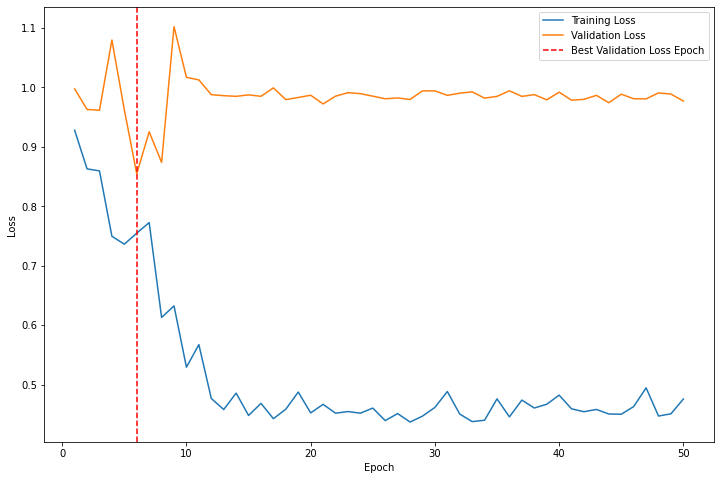

In [28]:
# plot the training and validation loss and accuracy and a vertical line on the x-axis at the epoch of the best validation loss
best_epoch = valid_losses.index(min(valid_losses))+1
plt.figure(figsize=(12,8))
plt.plot(range(1,num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1,num_epochs+1), valid_losses, label='Validation Loss')
plt.axvline(best_epoch, color='r', linestyle='--', label='Best Validation Loss Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [11]:
# load the ensemble model from the file
model.load_state_dict(torch.load('{}'.format(ensemble_model_name)))

<All keys matched successfully>

0.3575998
0.35097143
0.38132122
0.5662008
0.4959334
0.40926632
0.39753872
0.47969767
Highest Correlation Coefficient:  0.47753316199225376
Lowest Correlation Coefficient:  -0.5796853749113464


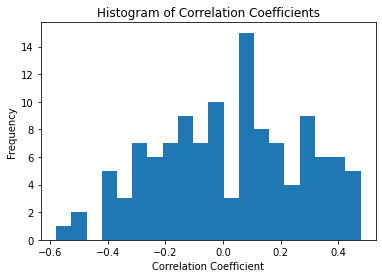

Mean Correlation Coefficient:  0.020857481299975635
Mean Correlation Coefficient:  0.020857481299975635


In [12]:
model.eval()
# display a side by side comparison of the original label and the predicted label
def display_side_by_side(original, prediction):
    #add title to the figure
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(original)
    ax.set_title('Original')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(prediction)
    ax.set_title('Prediction')
    # calculate the mean squared error
    mse = (original - prediction)**2
    # display mse next to the other comparisons
    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('MSE: {:.4f}'.format (mse.mean()))
    ax.imshow(mse)
    plt.show()

# display a figure of the mean squared error between the original label and the predicted label on matplotlib
def display_mse(original, prediction):
    mse = np.mean((original - prediction)**2)
    print('Mean Squared Error: ', mse)
    plt.imshow((original - prediction)**2)
    plt.show()

# print(training_labels[0].unsqueeze(0).numpy().shape)

# resized_original = training_labels[0].unsqueeze(0).numpy().reshape(8,29)
# resized_prediction = model(training_data[0].unsqueeze(0).to(device)).detach().cpu().numpy().reshape(8,29)

#draw a correlation coefficient graph between the original label and the predicted label
def draw_correlation_coefficient(original, prediction):
    # calculate the correlation coefficient
    corr_coeff = np.corrcoef(original, prediction)[0,1]
    # display the correlation coefficient
    print('Correlation Coefficient: ', corr_coeff)
    # plot the correlation coefficient graph
    plt.plot(original, prediction, 'o')
    plt.xlabel('Original')
    plt.ylabel('Prediction')
    plt.title('Correlation Coefficient: {:.2f}'.format(corr_coeff))
    plt.show()


#print out value ranges of prediction
# print('Prediction Range: ', np.min(resized_prediction), np.max(resized_prediction))

# display a side by side comparison of the original label and the predicted label
# display_side_by_side(resized_original,resized_prediction)
# display_mse(resized_original,resized_prediction)

# draw_correlation_coefficient(training_labels[0].unsqueeze(0).numpy(),model(training_data[0].unsqueeze(0).to(device)).detach().cpu().numpy())

#find out the correlation coefficient between the original label and the predicted label for the entire dataset
def find_correlation_coeff(model):
    # calculate the correlation coefficient
    corr_coeff_list = []
    # separate the pytorch dataset into the data and labels
    # set the model to evaluation mode
    
    
    # evaluate the model on the validation set
    for RAW_data, RAFT_data, BDCN_data, MFCC_data in zip(RAW_val_loader, RAFT_val_loader, BDCN_val_loader, MFCC_val_loader):
        
        image_batch1, labels = RAW_data
        image_batch2, _ = RAFT_data
        image_batch3, _ = BDCN_data
        image_batch4, _ = MFCC_data
        
        print(labels.cpu().numpy()[0][0])
        # print the range of labels


        # move tensors to GPU if CUDA is available
        if use_cuda:
            image_batch1, labels = image_batch1.to(device), labels.to(device)
            image_batch2, image_batch3, image_batch4 = image_batch2.to(device), image_batch3.to(device), image_batch4.to(device)
            #put model on gpu
            model = model.to(device)
            model.eval()
        
        # validation forward pass
        output = model(image_batch1, image_batch2, image_batch3, image_batch4)
        # calculate the correlation coefficient for every image in the batch
        # for every image in the batch
        for i in range(len(output)):
            # calculate the correlation coefficient
            corr_coeff = np.corrcoef(labels.cpu().numpy()[i].T, output[i].detach().cpu().numpy().T)[0,1]
            # append the correlation coefficient to the list
            corr_coeff_list.append(corr_coeff)
    # calculate the mean correlation coefficient
    mean_corr_coeff = np.mean(corr_coeff_list)
    #print the highest correlation coefficient and lowest correlation coefficient
    print('Highest Correlation Coefficient: ', max(corr_coeff_list))
    print('Lowest Correlation Coefficient: ', min(corr_coeff_list))

    # plot a histogram of the correlation coefficients
    plt.hist(corr_coeff_list, bins=20)
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.title('Histogram of Correlation Coefficients')
    plt.show()
    
    # display the mean correlation coefficient
    print('Mean Correlation Coefficient: ', mean_corr_coeff)
    return mean_corr_coeff

model.eval()
print ( 'Mean Correlation Coefficient: ', find_correlation_coeff(model))